# Agent Chat with Multimodal Models: DALLE  and GPT-4V

Requires: OpenAI V1. 

### Before everything starts, install AutoGen with the `lmm` option
```bash
pip install "pyautogen[lmm]>=0.2.3"
```

In [1]:
import json
import os
import pdb
import random
import re
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import PIL
import requests
from diskcache import Cache
from openai import OpenAI, AzureOpenAI
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data, gpt4v_formatter, get_pil_image
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

In [82]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview", "gpt4-vision"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt4-turbo", "gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

config_list_dalle = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["dalle"],
    },
)

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

In [83]:
config_list_dalle

[{'model': 'dalle',
  'api_key': '1fc7578697f9497885a4bf2e778faa07',
  'base_url': 'https://oai-vision-swe.openai.azure.com/',
  'api_type': 'azure',
  'api_version': '2024-02-01'}]

The `config_list_dalle` should be something like:

```python
[
    {
        'model': 'dalle',
        'api_key': 'Your API Key here',
        'api_version': '2024-02-15-preview'
    }
]
 ```

## Helper Functions

We first create a warpper for DALLE call, make the 

In [84]:
def dalle_call(client: AzureOpenAI, model: str, prompt: str, size: str, quality: str, n: int) -> str:
    """
    Generate an image using OpenAI's DALL-E model and cache the result.

    This function takes a prompt and other parameters to generate an image using OpenAI's DALL-E model.
    It checks if the result is already cached; if so, it returns the cached image data. Otherwise,
    it calls the DALL-E API to generate the image, stores the result in the cache, and then returns it.

    Args:
        client (OpenAI): The OpenAI client instance for making API calls.
        model (str): The specific DALL-E model to use for image generation.
        prompt (str): The text prompt based on which the image is generated.
        size (str): The size specification of the image. TODO: This should allow specifying landscape, square, or portrait modes.
        quality (str): The quality setting for the image generation.
        n (int): The number of images to generate.

    Returns:
    str: The image data as a string, either retrieved from the cache or newly generated.

    Note:
    - The cache is stored in a directory named '.cache/'.
    - The function uses a tuple of (model, prompt, size, quality, n) as the key for caching.
    - The image data is obtained by making a secondary request to the URL provided by the DALL-E API response.
    """
    # Function implementation...
    cache = Cache(".cache/")  # Create a cache directory
    key = (model, prompt, size, quality, n)
    if key in cache:
        return cache[key]



    # If not in cache, compute and store the result
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    cache[key] = img_data

    return img_data

Here is a helper function to extract image from a DALLE agent. We will show the DALLE agent later.

In [85]:
def extract_img(agent: Agent) -> PIL.Image:
    """
    Extracts an image from the last message of an agent and converts it to a PIL image.

    This function searches the last message sent by the given agent for an image tag,
    extracts the image data, and then converts this data into a PIL (Python Imaging Library) image object.

    Parameters:
        agent (Agent): An instance of an agent from which the last message will be retrieved.

    Returns:
        PIL.Image: A PIL image object created from the extracted image data.

    Note:
    - The function assumes that the last message contains an <img> tag with image data.
    - The image data is extracted using a regular expression that searches for <img> tags.
    - It's important that the agent's last message contains properly formatted image data for successful extraction.
    - The `_to_pil` function is used to convert the extracted image data into a PIL image.
    - If no <img> tag is found, or if the image data is not correctly formatted, the function may raise an error.
    """
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        assert isinstance(last_message[0], dict)
        img_data = last_message[0]["image_url"]["url"]

    pil_img = get_pil_image(img_data)
    return pil_img

## The DALLE Agent

In [86]:
class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            deployment_name = config_list[0]["model"]
            api_key = config_list[0]["api_key"]
            base_url = config_list[0]["base_url"]
            api_version = config_list[0]["api_version"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
        self._dalle_client = AzureOpenAI(api_key=api_key, azure_endpoint=base_url, api_version=api_version)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):
        # override and always "silent" the send out message;
        # otherwise, the print log would be super long!
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config):
        """Generate a reply using OpenAI DALLE call."""
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        # TODO: integrate with autogen.oai. For instance, with caching for the API call
        img_data = dalle_call(
            client=self._dalle_client,
            model="dalle",
            prompt=prompt,
            size="1024x1024",  # TODO: the size should be flexible, deciding landscape, square, or portrait mode.
            quality="standard",
            n=1,
        )

        img_data = _to_pil(img_data)  # Convert to PIL image

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

## Simple Example: Call directly from User

In [87]:
dalle = DALLEAgent(name="Dalle", llm_config={"config_list": config_list_dalle})

user_proxy = UserProxyAgent(
    name="User_proxy", system_message="A human admin.", human_input_mode="NEVER", max_consecutive_auto_reply=0
)

# Ask the question with an image
user_proxy.initiate_chat(
    dalle,
    message="""Create an image with white background, a happy robot is showing a sign with "I Love AutoGen".""",
)

User_proxy (to Dalle):

Create an image with white background, a happy robot is showing a sign with "I Love AutoGen".

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Create an image with white background, a happy robot is showing a sign with "I Love AutoGen".', 'role': 'assistant'}, {'content': [{'type': 'image_url', 'image_url': {'url': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024 at 0x1CF039223D0>}}], 'role': 'user'}], summary='', cost=({'total_cost': 0}, {'total_cost': 0}), human_input=[])

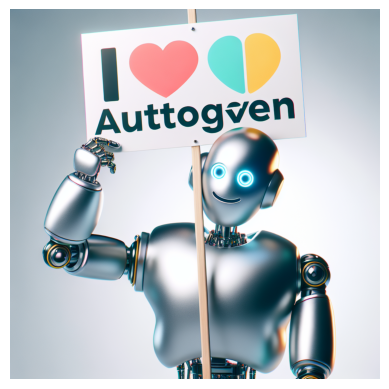

In [88]:
img = extract_img(dalle)

plt.imshow(img)
plt.axis("off")  # Turn off axis numbers
plt.show()

## Example With Critics: Iterate several times to improve

In [89]:
class DalleCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a DalleCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among
        its child agents: dalle and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=DalleCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        img_prompt = messages[-1]["content"]

        ## Define the agents
        self.critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""You need to improve the prompt of the figures you saw.
How to create a figure that is better in terms of color, shape, text (clarity), and other things.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!

""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.dalle = DALLEAgent(
            name="Dalle", llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0
        )

        # Data flow begins
        self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
        img = extract_img(self.dalle)
        plt.imshow(img)
        plt.axis("off")  # Turn off axis numbers
        plt.show()
        print("Image PLOTTED")

        for i in range(self._n_iters):
            # Downsample the image s.t. GPT-4V can take
            img = extract_img(self.dalle)
            smaller_image = img.resize((128, 128), Image.Resampling.LANCZOS)
            smaller_image.save("result.png")

            self.msg_to_critics = f"""Here is the prompt: {img_prompt}.
            Here is the figure <img result.png>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            """
            self.send(message=self.msg_to_critics, recipient=self.critics, request_reply=True)
            feedback = self._oai_messages[self.critics][-1]["content"]
            img_prompt = re.findall("PROMPT: (.*)", feedback)[0]

            self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
            img = extract_img(self.dalle)
            plt.imshow(img)
            plt.axis("off")  # Turn off axis numbers
            plt.show()
            print(f"Image {i} PLOTTED")

        return True, "result.jpg"

User (to DALLE Creator!):

Create an image with black background, a happy robot is showing a sign with "I Love Belgium".

--------------------------------------------------------------------------------
DALLE Creator! (to Dalle):

Create an image with black background, a happy robot is showing a sign with "I Love Belgium".

--------------------------------------------------------------------------------


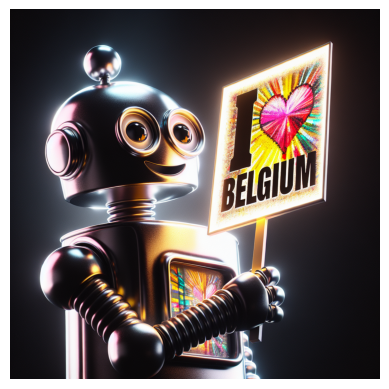

Image PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Create an image with black background, a happy robot is showing a sign with "I Love Belgium"..
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE Creator!):

CRITICS: The image needs to improve the visibility of the text on the sign as it's slightly hard to read. The color contrast between the text and the heart could be more pronounced. Additionally, the robot could be more obviously content or jovial to convey the message of happiness effectively.

PROMPT: Here is the updated prompt! Create an image with a sleek, matte-black background. Include a robot with a clear expression of joy and excitement, possibly with a smile or a 'thumbs up.' The robot is holding a sign that reads "I Love Belg

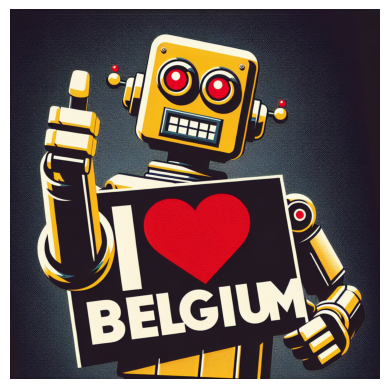

Image 0 PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Here is the updated prompt! Create an image with a sleek, matte-black background. Include a robot with a clear expression of joy and excitement, possibly with a smile or a 'thumbs up.' The robot is holding a sign that reads "I Love Belgium" in bold, legible white or yellow text that stands out against a bright red heart. Ensure the words are easily readable and make the heart symbol large and prominent for better visual impact..
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE Creator!):

CRITICS: The figure has improved in terms of the robot's joyful expression and the readability of the text. However, the "I Love Belgium" text could benefit from a slightly larger font size to fill the

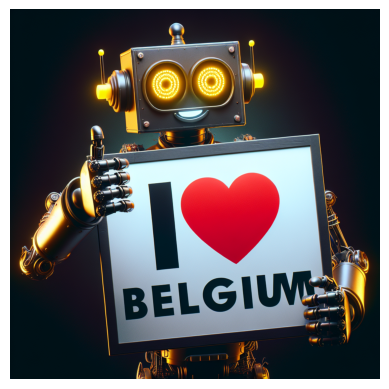

Image 1 PLOTTED
DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Create an image with black background, a happy robot is showing a sign with "I Love Belgium".', 'role': 'assistant'}, {'content': 'result.jpg', 'role': 'user'}], summary='result.jpg', cost=({'total_cost': 0}, {'total_cost': 0}), human_input=[])

In [92]:
creator = DalleCreator(
    name="DALLE Creator!",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt4_llm_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""Create an image with black background, a happy robot is showing a sign with "I Love Belgium"."""
)